# KAN-ODE

## KODE网络训练

### 安装依赖

In [40]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch.distributions as dists
import pandas as pd
from base_kan.ekan import EKAN 

### 定义网络
包含常规ODE和Neural ODE的SIR系统

In [42]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  # 用于记录neural_output

    def forward(self, t, y):
        S, I, R, A = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  # 记录neural_output
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        dA_dt = abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])

### 初始化模型参数

In [43]:
gamma = 0.007
beta = 2 * gamma  #根据实际情况，参数beta是参数gamma的具体倍数
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

### 初始化参数

In [44]:
intial = 0.  ##时间区间的初始值
last= 120.    ##时间区间的终值
step = 120   ##时间步长
y0 = torch.tensor([0.99, 0.01, 0.0, 0.0], requires_grad=True)  # 初始条件: S, I, R
t = torch.linspace(intial, last, step)  # 时间区间

### 无扰动部分

#### 生成真实数据

In [45]:
def get_data():
    gamma = 0.007
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I * (10*torch.exp(-a*t)+5)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

#### 定义损失函数
##### 使用仅与I相关的损失函数

In [46]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 3] - true_y[:, 3]) ** 2)

#### 定义准确率计算函数
##### 使用仅与I相关的准确率函数

In [47]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 3] - true_y[:, 3])
    correct = (diff < threshold).float().mean()
    return correct.item()

#### 定义差分机计算公式

In [48]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

#### 定义训练模型
##### 执行模型的训练

In [49]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(3000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

#### 进行训练

In [50]:
t, True_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.051992934197187424, Accuracy: 0.83%
Iter 100, Loss: 0.0008357390761375427, Accuracy: 19.17%
Iter 200, Loss: 0.00017216529522556812, Accuracy: 41.67%
Iter 300, Loss: 2.5689003450679593e-05, Accuracy: 97.50%
Iter 400, Loss: 5.535078798857285e-06, Accuracy: 100.00%
Iter 500, Loss: 3.3250285014219116e-06, Accuracy: 100.00%
Iter 600, Loss: 2.7019696062779985e-06, Accuracy: 100.00%
Iter 700, Loss: 2.237253511339077e-06, Accuracy: 100.00%
Iter 800, Loss: 1.8718191086009028e-06, Accuracy: 100.00%
Iter 900, Loss: 1.593863203197543e-06, Accuracy: 100.00%
Iter 1000, Loss: 1.3955269650978153e-06, Accuracy: 100.00%
Iter 1100, Loss: 1.2636163546630996e-06, Accuracy: 100.00%
Iter 1200, Loss: 1.1764934697566787e-06, Accuracy: 100.00%
Iter 1300, Loss: 1.1227792811041581e-06, Accuracy: 100.00%
Iter 1400, Loss: 1.26469512906624e-05, Accuracy: 100.00%
Iter 1500, Loss: 1.2775295772371464e-06, Accuracy: 100.00%
Iter 1600, Loss: 4.876733783021336e-06, Accuracy: 100.00%
Iter 1700, Loss: 1.3930

##### 将A进行差分

In [51]:
True_y[:,3] = forword_CF(True_y[:,3])
pred_y[:,3] = forword_CF(pred_y[:,3])

/tmp/ipykernel_1410041/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [52]:
tdata = {
    'Time': t.numpy(),
    'True_S': True_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': True_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': True_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
    'True_A': True_y.numpy()[:, 3],
    'Predicted_A': pred_y.detach().numpy()[:, 3],

}

dft = pd.DataFrame(tdata)

##### 保存成Excel文件

In [53]:
dft.to_excel('ZS-t.xlsx', index=False)

### 加扰动部分
#### 生成真实数据

In [54]:
def get_data():
    gamma = 0.007
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I * (10*torch.exp(-a*t)+5)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, y = get_data()

#### 加入噪声

##### 泊松分布的噪声

In [55]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = y * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
true_y = poisson_noise/10000
y = y/10000

#### 进行训练

In [56]:
t, Z_true_y, Z_pred_y, Z_neural_outputs = train()

Iter 0, Loss: 4.4113388867117465e-05, Accuracy: 86.67%
Iter 100, Loss: 4.1451246943324804e-05, Accuracy: 88.33%
Iter 200, Loss: 4.0510018152417615e-05, Accuracy: 88.33%
Iter 300, Loss: 4.0212315070675686e-05, Accuracy: 88.33%
Iter 400, Loss: 4.007760435342789e-05, Accuracy: 88.33%
Iter 500, Loss: 3.997109888587147e-05, Accuracy: 87.50%
Iter 600, Loss: 3.989656761405058e-05, Accuracy: 88.33%
Iter 700, Loss: 3.982330235885456e-05, Accuracy: 88.33%
Iter 800, Loss: 3.977482265327126e-05, Accuracy: 88.33%
Iter 900, Loss: 3.9749120332999155e-05, Accuracy: 88.33%
Iter 1000, Loss: 3.972389458795078e-05, Accuracy: 88.33%
Iter 1100, Loss: 3.971592741436325e-05, Accuracy: 88.33%
Iter 1200, Loss: 3.970279067289084e-05, Accuracy: 89.17%
Iter 1300, Loss: 3.970332909375429e-05, Accuracy: 88.33%
Iter 1400, Loss: 3.9694681618129835e-05, Accuracy: 89.17%
Iter 1500, Loss: 3.968993041780777e-05, Accuracy: 88.33%
Iter 1600, Loss: 4.0190163417719305e-05, Accuracy: 90.83%
Iter 1700, Loss: 8.745063678361475e-

##### 泊松分布扰动

In [57]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = True_y[:,3] * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
Z_true_y[:,3] = poisson_noise/10000

##### 差分计算

In [58]:
Z_pred_y[:,3] = forword_CF(Z_pred_y[:,3])

/tmp/ipykernel_1410041/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [59]:
tdata = {
    'Time': t.numpy(),
    'True_S': Z_true_y.numpy()[:, 0],
    'Predicted_S': Z_pred_y.detach().numpy()[:, 0],
    'True_I': Z_true_y.numpy()[:, 1],
    'Predicted_I': Z_pred_y.detach().numpy()[:, 1],
    'True_R': Z_true_y.numpy()[:, 2],
    'Predicted_R': Z_pred_y.detach().numpy()[:, 2],
    'True_A': Z_true_y.numpy()[:, 3],
    'Predicted_A': Z_pred_y.detach().numpy()[:, 3],
}

dft = pd.DataFrame(tdata)



##### 保存成Excel文件

In [60]:
dft.to_excel('ZS-zt.xlsx', index=False)

### 绘制结果并将图片结果保存
#### 训练阶段可视化

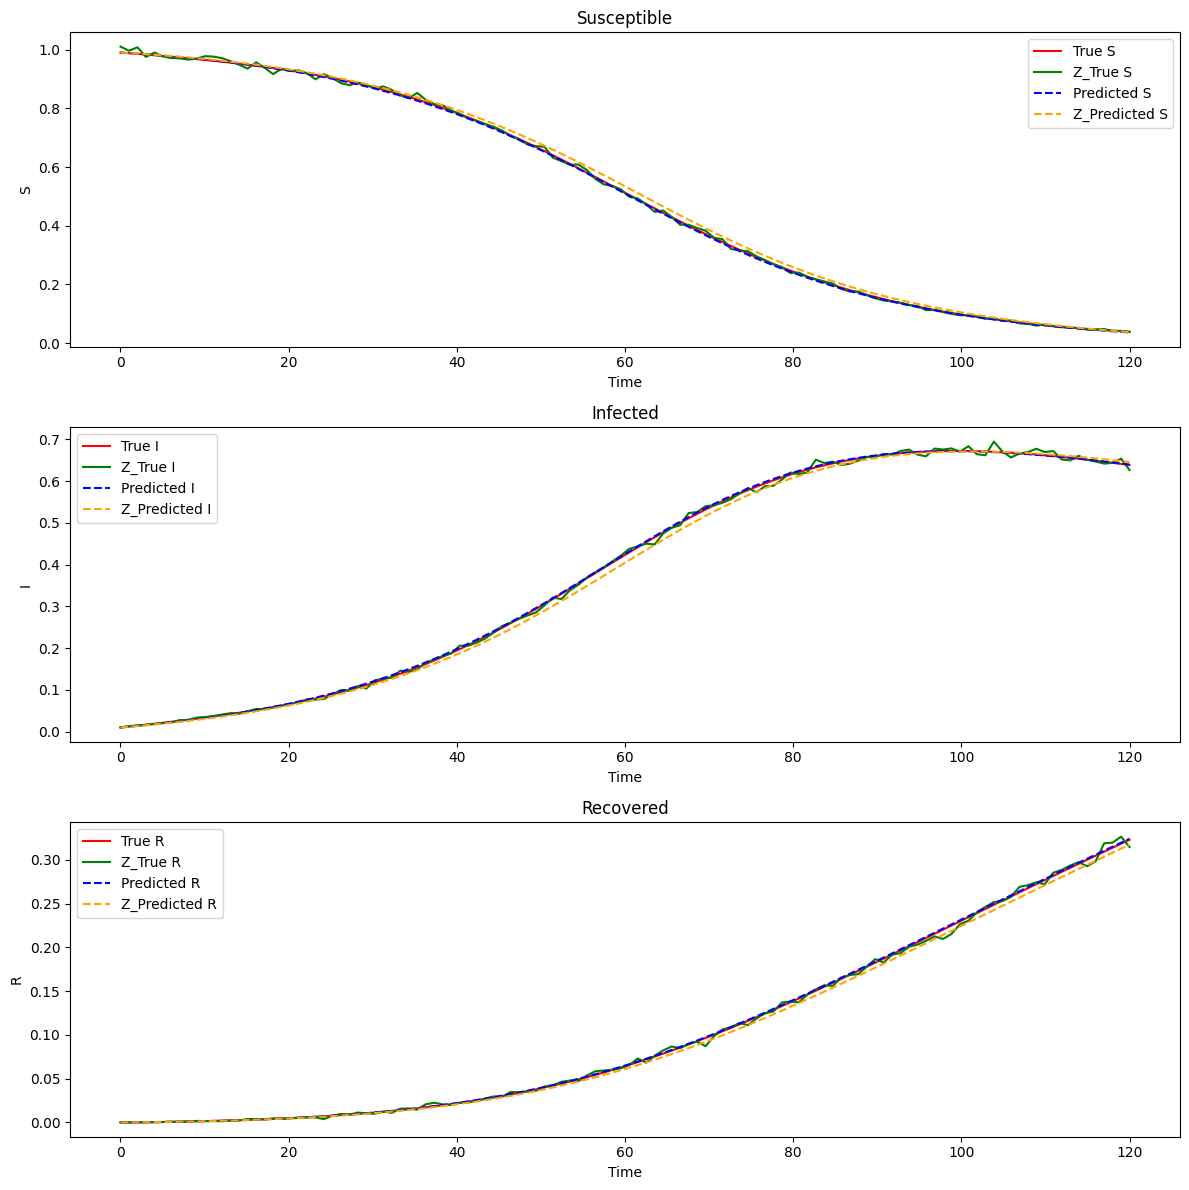

In [61]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), True_y.numpy()[:, 0], '-', label='True S', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 0], '-', label='Z_True S', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], '--', label='Predicted S', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 0], '--', label='Z_Predicted S', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), True_y.numpy()[:, 1], '-', label='True I', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 1], '-', label='Z_True I', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], '--', label='Predicted I', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 1], '--', label='Z_Predicted I', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), True_y.numpy()[:, 2], '-', label='True R', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 2], '-', label='Z_True R', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], '--', label='Predicted R', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 2], '--', label='Z_Predicted R', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')


plt.tight_layout()
plt.show()


##### 真实数据可视化

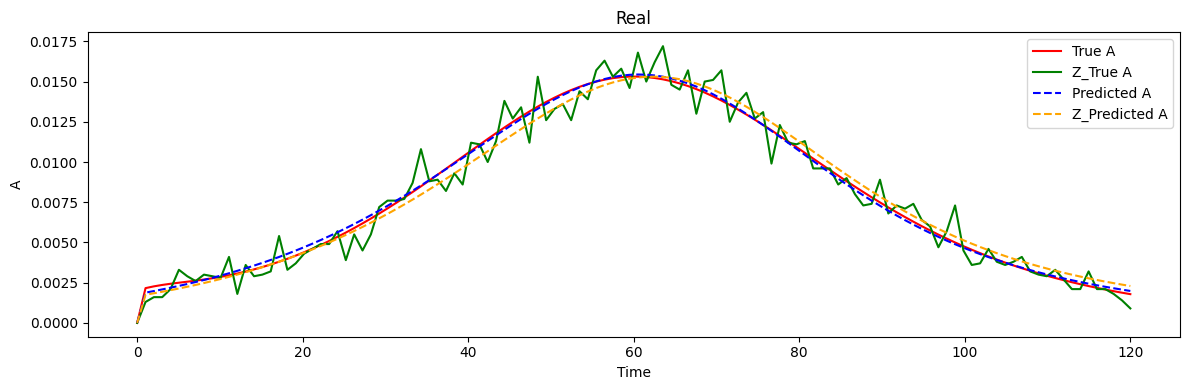

In [62]:
plt.figure(figsize=(12, 4))

plt.plot(t.numpy(), True_y.numpy()[:, 3], '-', label='True A', color='red')
plt.plot(t.numpy(), Z_true_y.detach().numpy()[:, 3], '-', label='Z_True A', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 3], '--', label='Predicted A', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 3], '--', label='Z_Predicted A', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')


plt.tight_layout()
plt.show()